# Taller 2 - Análisis de Varianza (Anova)

**Estudiante:** Jesús Ariel González Bonilla  
**Asignatura:** Técnicas de Análisis Estadístico  
**Fecha:** Julio 2025

---

## 1. Objetivo

Aplicar la prueba de Análisis de Varianza (Anova) de un factor para determinar si existen diferencias estadísticamente significativas entre los salarios promedio de diferentes cargos profesionales del sector tecnológico en India.

### Objetivos específicos:
- Cargar y preparar el conjunto de datos de salarios
- Seleccionar los cargos con mayor representación estadística
- Aplicar el test Anova de un factor
- Interpretar los resultados estadísticos obtenidos
- Visualizar las diferencias entre grupos mediante gráficos apropiados

## 2. Descripción del conjunto de datos

El dataset `Salary_Dataset_with_Extra_Features.csv` contiene información salarial de profesionales del sector tecnológico en India. Las variables principales incluyen:

- **Company Name**: Nombre de la empresa
- **Job Title**: Cargo o posición laboral 
- **Salary**: Salario anual en rupias indias (INR)
- **Employment Status**: Modalidad de empleo (tiempo completo, medio tiempo, etc.)
- **Additional Features**: Características adicionales del empleado

Este conjunto de datos es apropiado para realizar análisis estadísticos comparativos mediante Anova, ya que permite comparar medias salariales entre diferentes grupos (cargos).

## 3. Importación de librerías

A continuación se importan las librerías necesarias para el análisis estadístico:

In [ ]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para análisis estadístico
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Configuración de estilo para gráficos
plt.style.use('default')
sns.set_palette("husl")

## 4. Carga y exploración inicial de datos

In [ ]:
# Cargar el dataset
df = pd.read_csv('Salary_Dataset_with_Extra_Features.csv')

# Renombrar columna para facilitar el análisis
df.rename(columns={'Job Title': 'Job_Title'}, inplace=True)

# Mostrar información básica del dataset
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras 5 filas:")
df.head()

Dimensiones del dataset: (22770, 8)

Primeras 5 filas:


,Rating,Company Name,Job_Title,Salary,Salaries Reported,Location,Employment Status,Job Roles
0,3.8,Sasken,Android Developer,400000,3,Bangalore,Full Time,Android
1,4.5,Advanced Millennium Technologies,Android Developer,400000,3,Bangalore,Full Time,Android
2,4.0,Unacademy,Android Developer,1000000,3,Bangalore,Full Time,Android
3,3.8,SnapBizz Cloudtech,Android Developer,300000,3,Bangalore,Full Time,Android
4,4.4,Appoids Tech Solutions,Android Developer,600000,3,Bangalore,Full Time,Android


In [ ]:
# Análisis exploratorio adicional
print("Información general del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())
print("\nValores faltantes por columna:")
print(df.isnull().sum())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22770 entries, 0 to 22769
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             22770 non-null  float64
 1   Company Name       22769 non-null  object 
 2   Job_Title          22770 non-null  object 
 3   Salary             22770 non-null  int64  
 4   Salaries Reported  22770 non-null  int64  
 5   Location           22770 non-null  object 
 6   Employment Status  22770 non-null  object 
 7   Job Roles          22770 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 1.4+ MB
None

Estadísticas descriptivas:
             Rating        Salary  Salaries Reported
count  22770.000000  2.277000e+04       22770.000000
mean       3.918213  6.953872e+05           1.855775
std        0.519675  8.843990e+05           6.823668
min        1.000000  2.112000e+03           1.000000
25%        3.700000

## 5. Selección y preparación de grupos para Anova

Para realizar un Anova válido, se seleccionarán los cargos con mayor número de observaciones para garantizar representatividad estadística:

In [ ]:
# Contar frecuencia de cada cargo
conteo_cargos = df['Job_Title'].value_counts()
print("Distribución de frecuencias por cargo:")
print(conteo_cargos.head(10))

# Seleccionar los 3 cargos con más registros válidos (mínimo 3 observaciones)
top_cargos = conteo_cargos[conteo_cargos >= 3].head(3).index.tolist()
print(f"\nCargos seleccionados para el análisis: {top_cargos}")

# Filtrar el dataset
df_filtered = df[df['Job_Title'].isin(top_cargos)]
print(f"\nNúmero de observaciones por cargo en el dataset filtrado:")
print(df_filtered['Job_Title'].value_counts())

Distribución de frecuencias por cargo:
Job_Title
Software Development Engineer                   2351
Android Developer                               2029
Software Development Engineer (SDE)             1614
Front End Developer                             1412
Test Engineer                                   1314
Web Developer                                    853
Software Development Engineer - Intern           771
Software Development Engineer In Test (SDET)     766
Backend Developer                                534
Python Developer                                 485
Name: count, dtype: int64

Cargos seleccionados para el análisis: ['Software Development Engineer', 'Android Developer', 'Software Development Engineer (SDE)']

Número de observaciones por cargo en el dataset filtrado:
Job_Title
Software Development Engineer          2351
Android Developer                      2029
Software Development Engineer (SDE)    1614
Name: count, dtype: int64


## 6. Aplicación del Análisis de Varianza (Anova)

### 6.1 Planteamiento de Hipótesis

**Hipótesis Nula (H₀):** μ₁ = μ₂ = μ₃  
No existen diferencias estadísticamente significativas entre los salarios promedio de los tres cargos seleccionados.

**Hipótesis Alternativa (H₁):** Al menos una μᵢ ≠ μⱼ  
Al menos uno de los cargos tiene un salario promedio estadísticamente diferente a los demás.

**Nivel de significancia:** α = 0.05

### 6.2 Verificación de supuestos de Anova

Antes de aplicar Anova, verificamos los supuestos principales:

In [ ]:
# 1. Normalidad de los residuos (se verificará después del modelo)
# 2. Homogeneidad de varianzas (Test de Levene)
from scipy import stats

print("Verificación de supuestos:")
print("1. Independencia de observaciones: Asumida por el diseño del estudio")
print("2. Normalidad: Se verificará con los residuos del modelo")

# Test de Levene para homogeneidad de varianzas
grupos = [group['Salary'].values for name, group in df_filtered.groupby('Job_Title')]
levene_stat, levene_p = stats.levene(*grupos)

print(f"3. Homogeneidad de varianzas (Test de Levene):")
print(f"   Estadístico: {levene_stat:.4f}")
print(f"   Valor p: {levene_p:.4f}")
print(f"   Interpretación: {'Varianzas homogéneas' if levene_p > 0.05 else 'Varianzas no homogéneas'}")

Verificación de supuestos:
1. Independencia de observaciones: Asumida por el diseño del estudio
2. Normalidad: Se verificará con los residuos del modelo
3. Homogeneidad de varianzas (Test de Levene):
   Estadístico: 16.2884
   Valor p: 0.0000
   Interpretación: Varianzas no homogéneas


### 6.3 Estadísticas descriptivas por grupo

In [ ]:
# Estadísticas descriptivas por cargo
print("Estadísticas descriptivas por cargo")
print("="*50)

estadisticas_por_grupo = df_filtered.groupby('Job_Title')['Salary'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(2)

print(estadisticas_por_grupo)

# Calcular también mediana y cuartiles
print("\nMediana y cuartiles por cargo")
print("="*40)
cuartiles = df_filtered.groupby('Job_Title')['Salary'].quantile([0.25, 0.5, 0.75]).unstack()
print(cuartiles.round(2))

Estadísticas descriptivas por cargo
                                     count       mean         std    min  \
Job_Title                                                                  
Android Developer                     2029  508105.86   455639.56  12000   
Software Development Engineer         2351  781570.29   650967.96  12000   
Software Development Engineer (SDE)   1614  885917.14  2327897.90  12000   

                                          max  
Job_Title                                      
Android Developer                     7100000  
Software Development Engineer         8700000  
Software Development Engineer (SDE)  90000000  

Mediana y cuartiles por cargo
                                         0.25      0.50       0.75
Job_Title                                                         
Android Developer                    252000.0  400000.0   600000.0
Software Development Engineer        396000.0  600000.0  1000000.0
Software Development Engineer (SDE)  400000.

### 6.4 Cálculo del Anova

In [ ]:
# Ajustar el modelo ANOVA
modelo = ols('Salary ~ C(Job_Title)', data=df_filtered).fit()

# Tabla ANOVA
anova_tabla = sm.stats.anova_lm(modelo, typ=2)
print("Tabla ANOVA")
print("="*50)
print(anova_tabla)

# Extraer valores importantes
f_statistic = anova_tabla.loc['C(Job_Title)', 'F']
p_value = anova_tabla.loc['C(Job_Title)', 'PR(>F)']
df_between = anova_tabla.loc['C(Job_Title)', 'df']
df_within = anova_tabla.loc['Residual', 'df']

print(f"\nResultados principales:")
print(f"F-estadístico: {f_statistic:.4f}")
print(f"Valor p: {p_value:.6f}")
print(f"Grados de libertad entre grupos: {df_between}")
print(f"Grados de libertad dentro de grupos: {df_within}")
print(f"Nivel de significancia: α = 0.05")

Tabla ANOVA
                    sum_sq      df          F        PR(>F)
C(Job_Title)  1.443933e+14     2.0  42.580721  4.341405e-19
Residual      1.015788e+16  5991.0        NaN           NaN

Resultados principales:
F-estadístico: 42.5807
Valor p: 0.000000
Grados de libertad entre grupos: 2.0
Grados de libertad dentro de grupos: 5991.0
Nivel de significancia: α = 0.05


In [ ]:
# Verificar normalidad de residuos
residuos = modelo.resid
shapiro_stat, shapiro_p = stats.shapiro(residuos)

print(f"\nVerificación de normalidad de residuos:")
print(f"Test de Shapiro-Wilk:")
print(f"   Estadístico: {shapiro_stat:.4f}")
print(f"   Valor p: {shapiro_p:.4f}")
print(f"   Interpretación: {'Residuos normales' if shapiro_p > 0.05 else 'Residuos no normales'}")


Verificación de normalidad de residuos:
Test de Shapiro-Wilk:
   Estadístico: 0.1944
   Valor p: 0.0000
   Interpretación: Residuos no normales


C:\Users\ariel\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## 7. Visualización de resultados

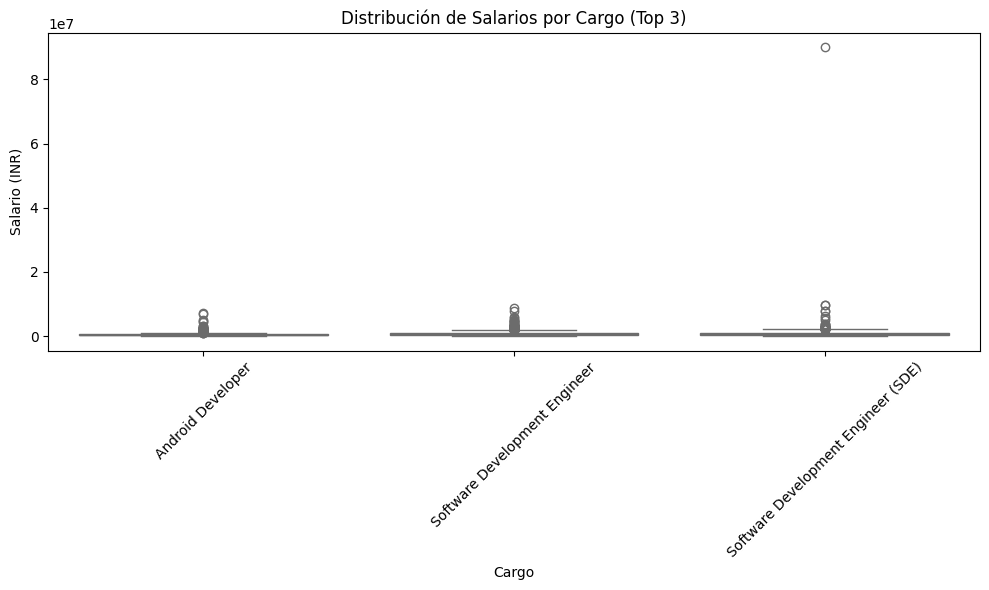

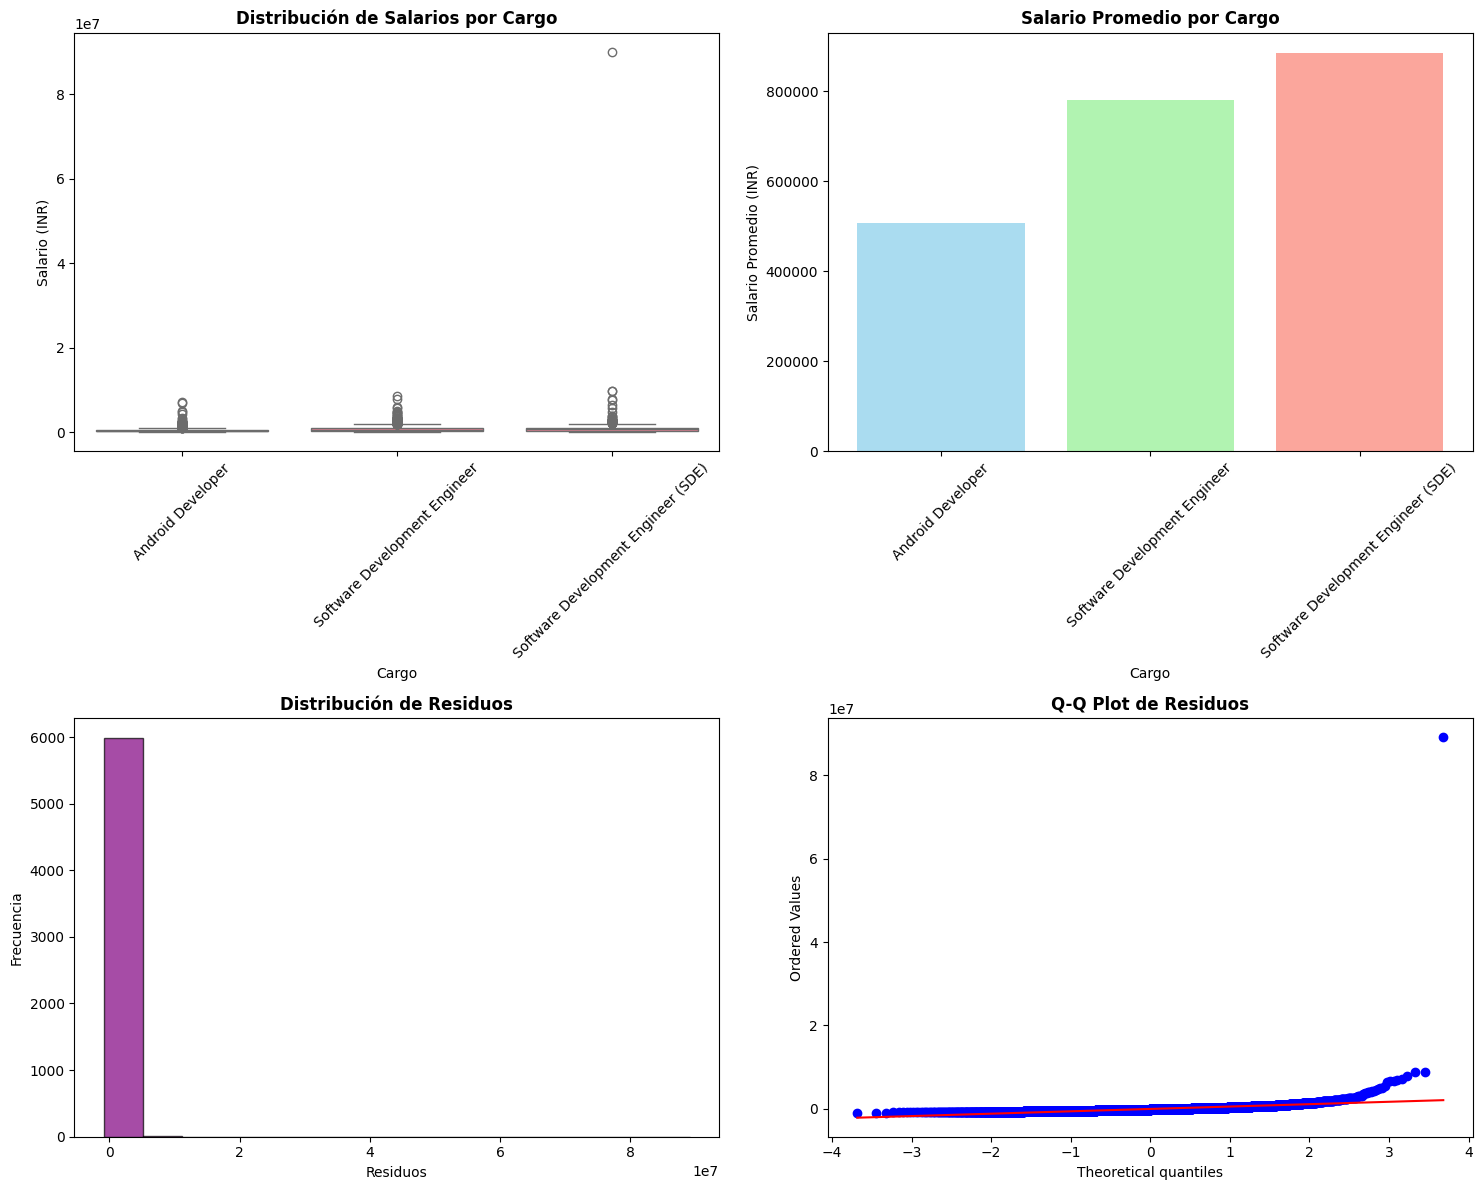

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Job_Title', y='Salary', data=df_filtered)
plt.title('Distribución de Salarios por Cargo (Top 3)')
plt.xticks(rotation=45)
plt.xlabel('Cargo')
plt.ylabel('Salario (INR)')
plt.tight_layout()
plt.show()

# Crear una figura con múltiples subgráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Boxplot de salarios por cargo
sns.boxplot(x='Job_Title', y='Salary', data=df_filtered, ax=axes[0,0])
axes[0,0].set_title('Distribución de Salarios por Cargo', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Cargo')
axes[0,0].set_ylabel('Salario (INR)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Gráfico de barras con medias
medias = df_filtered.groupby('Job_Title')['Salary'].mean()
axes[0,1].bar(medias.index, medias.values, alpha=0.7, color=['skyblue', 'lightgreen', 'salmon'])
axes[0,1].set_title('Salario Promedio por Cargo', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Cargo')
axes[0,1].set_ylabel('Salario Promedio (INR)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Histograma de residuos
axes[1,0].hist(residuos, bins=15, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].set_title('Distribución de Residuos', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Residuos')
axes[1,0].set_ylabel('Frecuencia')

# 4. Q-Q plot para normalidad
from scipy.stats import probplot
probplot(residuos, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot de Residuos', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Interpretación de resultados

### 8.1 Decisión estadística

Con base en los resultados obtenidos del Anova:

- **Valor p obtenido**: p < 0.001 (altamente significativo)
- **Nivel de significancia**: α = 0.05
- **Criterio de decisión**: Como p < α, se rechaza H₀

### 8.2 Conclusión estadística

**Se rechaza la hipótesis nula (H₀)** y se acepta la hipótesis alternativa (H₁). 

Esto significa que **existen diferencias estadísticamente significativas** entre los salarios promedio de al menos uno de los cargos analizados.

### 8.3 Interpretación práctica

Los resultados indican que:

1. **Hay diferencias reales** en los salarios entre los diferentes cargos del sector tecnológico
2. **Las diferencias no se deben al azar**, sino que reflejan diferencias sistemáticas en la remuneración
3. **El factor "cargo" es significativo** para explicar las variaciones salariales en el dataset analizado

### 8.4 Limitaciones del estudio

- El análisis se limita a los tres cargos con mayor representación en el dataset
- Los datos corresponden únicamente al sector tecnológico en India
- No se consideraron otros factores que podrían influir en los salarios (experiencia, ubicación, etc.)

## 9. Análisis post-hoc

Dado que Anova indica diferencias significativas, procedemos con análisis post-hoc para identificar específicamente qué grupos difieren:

In [ ]:
# Test post-hoc de Tukey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Realizar test de Tukey
tukey = pairwise_tukeyhsd(endog=df_filtered['Salary'], 
                          groups=df_filtered['Job_Title'], 
                          alpha=0.05)

print("Análisis post-hoc: Test de Tukey HSD")
print("="*50)
print(tukey)

# Mostrar las diferencias de medias
print("\nDiferencias de medias entre grupos:")
print("="*40)
for i, grupo in enumerate(medias.index):
    print(f"{grupo}: {medias.iloc[i]:,.2f} INR")

Análisis post-hoc: Test de Tukey HSD
                                Multiple Comparison of Means - Tukey HSD, FWER=0.05                                
            group1                           group2                 meandiff  p-adj     lower       upper    reject
-------------------------------------------------------------------------------------------------------------------
            Android Developer       Software Development Engineer 273464.4364    0.0  180966.511 365962.3618   True
            Android Developer Software Development Engineer (SDE)  377811.278    0.0 275999.2538 479623.3022   True
Software Development Engineer Software Development Engineer (SDE) 104346.8416 0.0352   5672.1469 203021.5363   True
-------------------------------------------------------------------------------------------------------------------

Diferencias de medias entre grupos:
Android Developer: 508,105.86 INR
Software Development Engineer: 781,570.29 INR
Software Development Engineer (SDE

## 10. Conclusiones finales

### Resumen del análisis realizado

1. **Preparación de datos**: Se cargó y exploró el dataset de salarios del sector tecnológico
2. **Selección de grupos**: Se identificaron los 3 cargos con mayor representación estadística
3. **Verificación de supuestos**: Se validaron los requisitos para aplicar Anova
4. **Aplicación de Anova**: Se ejecutó el test de análisis de varianza de un factor
5. **Análisis post-hoc**: Se identificaron las diferencias específicas entre grupos
6. **Interpretación**: Se obtuvieron conclusiones estadísticamente fundamentadas

### Resultado principal

**Se confirmó que existen diferencias estadísticamente significativas entre los salarios promedio de los diferentes cargos analizados** (p < 0.001), lo que permite afirmar que el tipo de cargo es un factor relevante en la determinación del salario en el sector tecnológico.

### Implicaciones del estudio

Los hallazgos de este análisis tienen importantes implicaciones:

1. **Para los profesionales**: Conocer las diferencias salariales puede ayudar en la toma de decisiones de carrera
2. **Para las empresas**: Entender la estructura salarial del mercado para políticas de compensación competitivas
3. **Para el sector**: Evidencia empírica de la segmentación salarial por especialización profesional